**В этом ноутбуке** нет новых идей, скорее просто оформленное финальное решение по поиску точки посадки пассажира и предложение метрики с более общими выводами.

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import \
    KMeans, \
    AgglomerativeClustering, \
    DBSCAN, \
    SpectralClustering

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

### 1. Поиск точки посадки пассажира

1) Основная гипотеза состоит в том, что если водитель не успевает поставить статус 2 в нужное время, то точку посадки можно определить по набору точек, близких друг к другу (причем "близость" определяется не только координатами, но и другими фичами). 

2) Набор точек находится с помощью методов кластеризации: проводится кластеризация точек со статусом 1 и нескольких точек со статусами 0 и 2 на три класса, средний класс (по временным меткам) считаем кластером "ожидания" - в это время водитель ждал пассажира. 

3) Тогда если мы решаем, что водитель поставил статус 2 не вовремя, то в качестве точки посадки пассажира берем последнюю (по хронологии) точку из кластера "ожидания".

4) Решение о том, вовремя был поставлен статус 2 или нет, принимается по значению среднего межкластерного расстояния. Если оно меньше некоторого порога, то точки там действительно "кучкуются" достаточно хорошо, и скорее всего это действительно кластер "ожидания". В качестве порога берется 0.1-квантиль всех межкластерных расстояний, т.е. доля "ошибок" водителей - 10%.



**Имплементация:**

Датасет со сгенерированными фичами

In [3]:
data = pd.read_csv('data/3k_data_features', index_col=0)
data.head(2)

,status,y,ts,x,session,begin,delay,dist,av_speed,x_diff,y_diff,angle
0,0,0.000000,0,0.000000,0,1,0,0.000000,NaN,0.000000,0.000000,0.000000
1,0,0.291129,9,-0.644802,0,0,9,0.707478,0.078609,-0.644802,0.291129,2.717491


Последние точки в кластерах ожидания и межкластерные расстояния:

In [4]:
def clustering_prediction(fit_predict_methods, data):
    session_values = np.unique(data.session.values)

    session_predictions = []
    cluster_distances = []
    for i, session in tqdm_notebook(enumerate(session_values), total=len(session_values)):
        
        # Данные рассматриваемой сессии
        session_data = data[data.session == session]
        session_data = session_data[session_data.ts != 0]
        
        columns = ['x', 'y', 'ts', 'av_speed', 'angle', 'dist']

        # Выделяем из данных сессии данные с нужными статусами
        status_1_data = session_data[session_data.status == 1].loc[:, columns].copy()
        status_0_data = session_data[session_data.status == 0].loc[:, columns].copy()
        status_2_data = session_data[session_data.status == 2].loc[:, columns].copy()
        
        # Соединяем всё вместе
        status_data_w_dist = pd.concat([status_0_data.iloc[-2:, :],
                                 status_1_data,
                                 status_2_data.iloc[:2, :]],
                                 axis=0)

        status_data = status_data_w_dist.loc[:, columns[:-1]].copy()
        
        #Стандартизуем данные
        scaler = StandardScaler(with_mean=False)
        status_data.iloc[:, :] = scaler.fit_transform(status_data.copy())
        
        x_preds = []
        y_preds = []
        dist_preds = []
        for method in fit_predict_methods:
            pred = method(status_data)
            
            # Найдём точки, где сменяется кластер
            candidates = []
            for j in range(len(pred) - 1):
                if pred[j] != pred[j+1]:
                    candidates.append(j)
            
            # Если кластера всего два, то возьмём последнюю рассматриваемую
            # точку в качестве правой границы
            if len(candidates) == 1:
                candidates.append(len(pred) - 1)
            
            # Предсказания и среднее расстояние в кластере
            x_preds.append(status_data_w_dist['x'].values[candidates[-1]])
            y_preds.append(status_data_w_dist['y'].values[candidates[-1]])
            dist_preds.append(np.mean(status_data_w_dist['dist'].values[candidates[0]:candidates[-1]+1]))
            
            
        x_pred = np.mean(x_preds)
        y_pred = np.mean(y_preds)
        
        session_predictions.append([i, x_pred, y_pred])
        cluster_distances.append(np.mean(dist_preds))
        
    return np.array(session_predictions), np.array(cluster_distances)

fit_predict_methods = [KMeans(n_clusters=3,
                            random_state=42,
                            n_init=100,
                            max_iter=1000,
                            n_jobs=-1).fit_predict,
                       AgglomerativeClustering(n_clusters=3,
                                               linkage='ward').fit_predict,
                       SpectralClustering(n_clusters=3, n_jobs=-1).fit_predict]
                       
                       
predictions, cluster_distances = clustering_prediction(fit_predict_methods, data)

Вспомогательная функция для поиска первых точек со статусом 2

In [5]:
def first_status_2(data):
    d = {}
    
    session_values = np.unique(data.session.values)
    for session in tqdm_notebook(session_values):
        session_data = data[data.session == session]
        pickup_row = session_data[session_data.status == 2].head(1)
        d[session] = (pickup_row.x.values[0], pickup_row.y.values[0]) 
        
    return d

По последним точкам кластеров и межкластерным расстояниям получаем финальные предсказания.

Будем, также, сохранять, каким из способов было получено предсказание (0 - метод кластеризации, 1 - последняя точка со статусом 2).

In [6]:
def final_preds(predictions, cluster_distances):
    # пороговое значение
    threshold = np.quantile(cluster_distances, 0.1)
    print(f'Пороговое значение межкластерного расстояния: {threshold}')

    valid_predictions = predictions[cluster_distances < threshold]

    preds = {}
    for pred in valid_predictions:
        preds[int(pred[0])] = (pred[1], pred[2], 0)
    
    first2 = first_status_2(data)

    for key in first2:
        if key not in preds:
            preds[key] = (first2[key][0], first2[key][1], 1)
            
    return preds

Взглянем на вид предсказаний

In [7]:
preds = final_preds(predictions, cluster_distances)

Пороговое значение межкластерного расстояния: 1.1200906612100876


In [8]:
preds[1], preds[100]

((467.8795440394896, 1009.9926489507196, 1),
 (373.0633040684311, -1113.3754465019024, 1))

То есть словарь имеет вид {номер сессии: точка посадки}

### 2. Метрика

**Идейно:**

Итак, поездки можно разделить на два типа:

1) Водитель вовремя включил статус 2.

2) Водитель опоздал с включением статуса 2. Тогда в статусе 1 есть набор точек, соответствующий "ожиданию" пассажира.

При этом случай (1) встречается гораздо чаще случая (2). Тогда логично в качестве метрики взять расстояние до первой (хронологически) точки со статусом 2 и применить некоторую регуляризацию: штрафовать метрику, если предсказанная точка слишком далеко от кластера "ожидания". 

**Формально:**

Пусть к точкам со статусом 1 сессии с номером i применили кластеризацию на 3 кластера. 

Пусть $a_i$ - последняя по времени точка среднего кластера (кластера ожидания).

Пусть $b_i$ - первая точка со статусом 2 в сессии.

Пусть $ans_i$ - предсказанная точка посадки пассажира для данной сессии.

Тогда возьмем в качестве метрики:

$$ f(a_i, b_i, ans_i) = \rho(ans_i, b_i) + \alpha \rho(ans_i, a_i)$$

Где $\alpha $ - некоторый параметр регуляризации, $\rho$ - евклидово расстояние.

Тогда оценка качества предсказаний для многих сессий:

$$ F(a, b, ans) = \frac{1}{N} \sum_{i=1}^N f(a_i, b_i, ans_i)$$

**Имплементация:**

In [9]:
eval_dict = {}

first_st2 = first_status_2(data)
for key, cluster_pred in zip(first_st2, predictions):
    cluster_point = (cluster_pred[1], cluster_pred[2])
    first2_point = first_st2[key]
    eval_dict[key] = [first2_point, cluster_point]
    
eval_df = pd.DataFrame.from_dict(eval_dict, orient='index',
                                 columns=['cluster_pred', 'first_status2'])
    
def dist(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + \
                   (point1[1] - point2[1])**2)

def MyMetric(eval_dict, preds, alpha=0.1):
    copy_eval = eval_df.copy()
    metrics = []
    for key in eval_dict:
        a = eval_dict[key][0]
        b = eval_dict[key][1]
        metrics.append(alpha*dist(a, preds[key]) + \
                       dist(b, preds[key]))
        
    return metrics

Значение метрики на нашем решении:

Значение метрики: 28.913263442291406


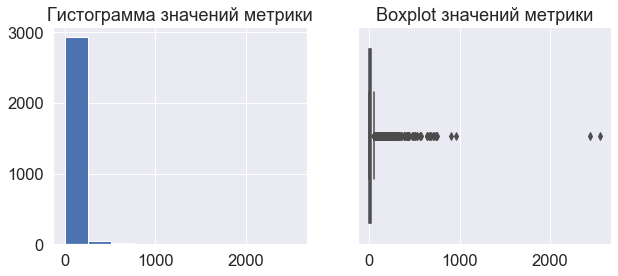

In [10]:
def plot_metrics(metrics):
    plt.figure(figsize=(10, 4))

    plt.subplot(121)
    plt.title('Гистограмма значений метрики')
    plt.hist(metrics, bins=10)

    plt.subplot(122)
    plt.title('Boxplot значений метрики')
    sns.boxplot(metrics)

    plt.show()

metrics = MyMetric(eval_dict, preds)

print(f'Значение метрики: {np.mean(metrics)}')

plot_metrics(metrics)

Значение после удаления выборосов: 13.494926126786842


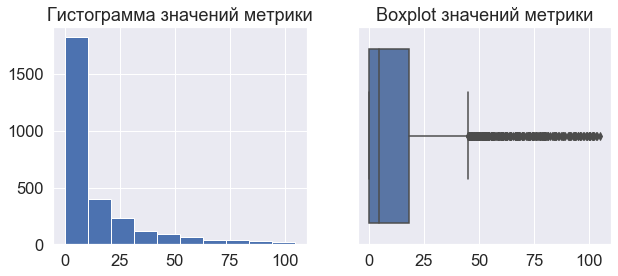

In [11]:
q = np.quantile(metrics, q=0.95)
metrics = np.array(metrics)
metrics = metrics[np.where(metrics < q)[0]]
print(f'Значение после удаления выборосов: {np.mean(metrics)}')
plot_metrics(metrics)

### 3. Предсказания

Сохраним полученные предсказания.

Затем, визуализирем некоторые из них.

Рассмотрим случайную выборку из нескольких сессий. 

Визуализируем траекторию поездки вместе со статусами, проставленными водителем и предсказанной нами точкой посадки.

Сделаем это и для сессий, для которых был выбран первый метод предсказания, и для остальных.

In [26]:
preds_data = pd.DataFrame(preds).T
preds_data.columns = ['x', 'y', 'method']
preds_data = preds_data.sort_index()

preds_data.head()

,x,y,method
0,537.323154,73.614187,1.0
1,467.879544,1009.992649,1.0
2,-698.044056,-39.040766,1.0
3,-140.035784,2103.199406,1.0
4,-1033.518299,-107.762341,1.0


Сохраним, также, полученные предсказания в отдельный файл.

In [47]:
preds_data.to_csv('data/3k_predictions.csv')

Сессии, для которых было сделано предсказание с помощью методов кластеризации.

In [34]:
alg_0_sample = preds_data[preds_data.method == 0].sample(n=6,
                                                         random_state=123)

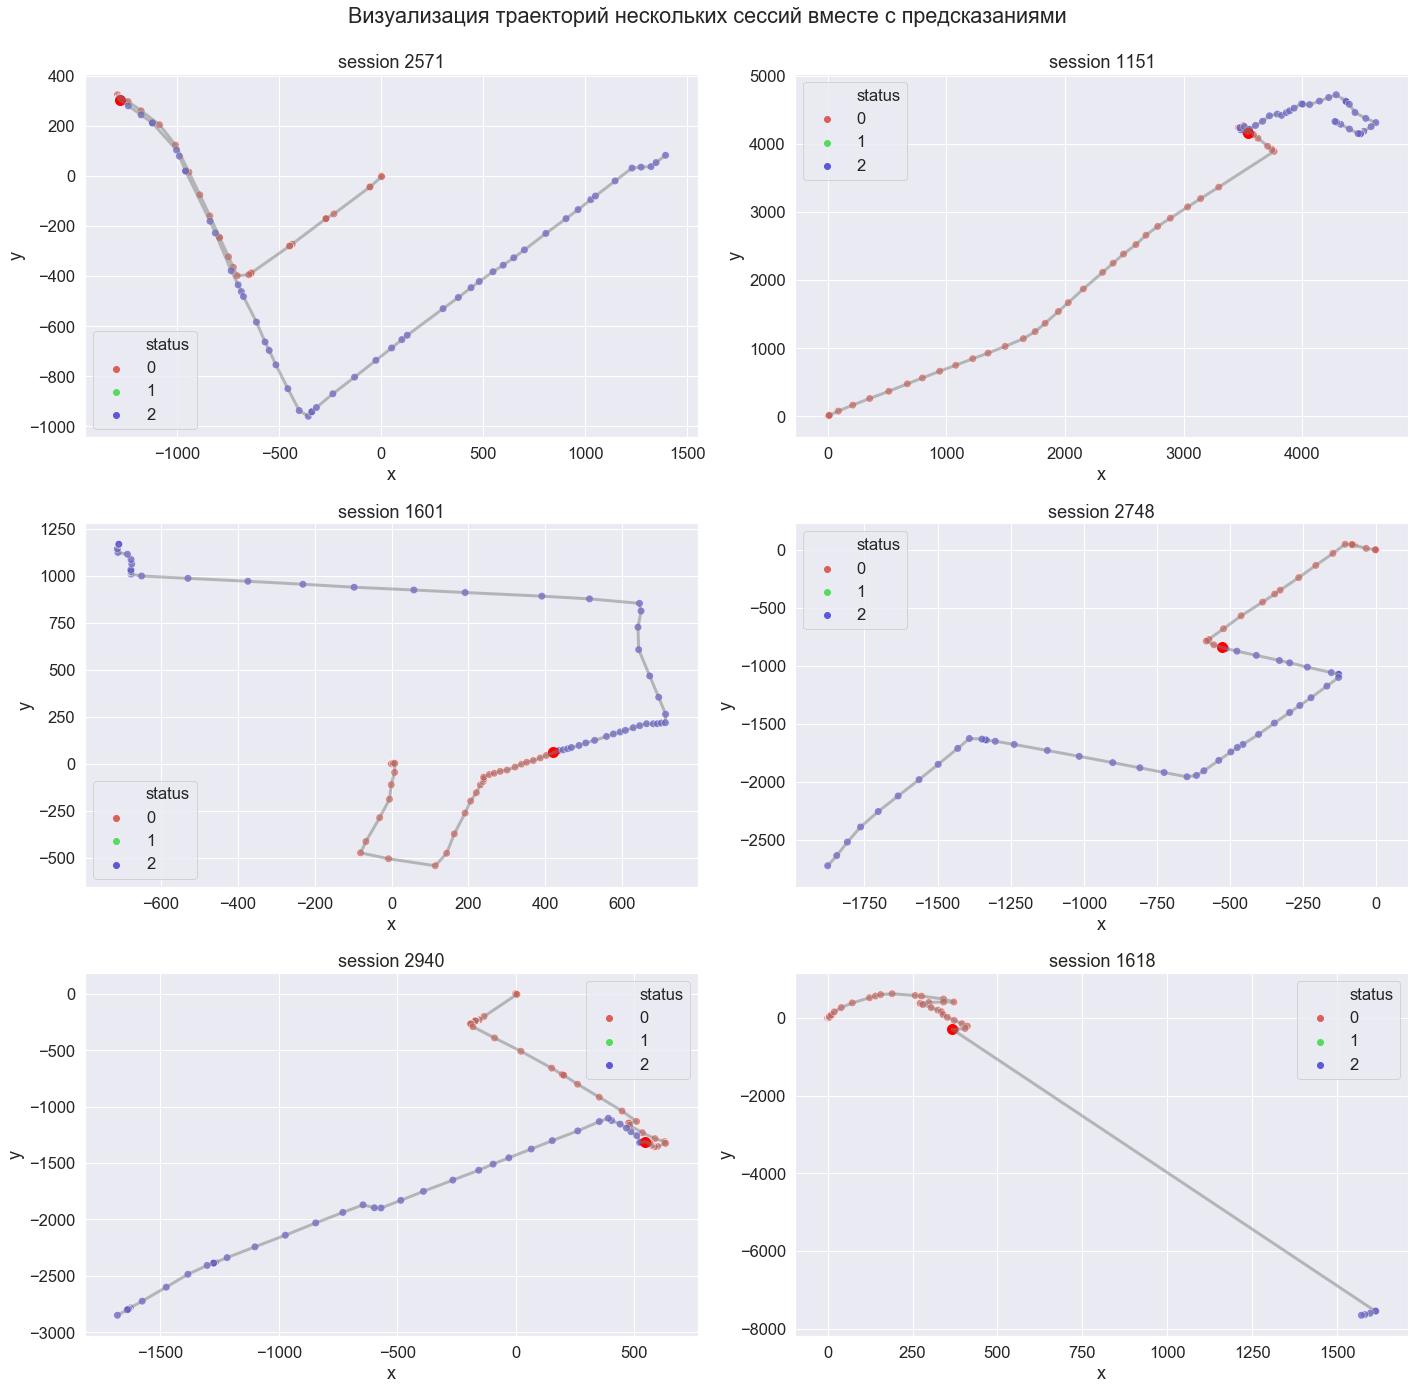

In [42]:
plt.figure(figsize=(20, 19))
plt.suptitle('Визуализация траекторий нескольких сессий \
вместе с предсказаниями', y=1.02, x=0.5)

for i, index in enumerate(alg_0_sample.index):
    plt.subplot(3, 2, i+1)
    
    session = data[data.session == index]
    
    plt.plot(session.x, session.y, alpha=0.5, color='grey', lw=3)
    
    sns.scatterplot(x='x', y='y', data=session, hue='status',
                    palette=sns.color_palette('hls', 3), alpha=0.7, s=60)
    plt.scatter(alg_0_sample.iloc[i, 0], alg_0_sample.iloc[i, 1],
                color='red', s=100, alpha=1)
    
    plt.title(f'session {index}')
    plt.xlabel('x')
    plt.ylabel('y')
    
plt.tight_layout()

Сессии, для которых было сделано предсказание с помощью поиска смены статуса.

In [45]:
alg_1_sample = preds_data[preds_data.method == 1].sample(n=6,
                                                         random_state=123)

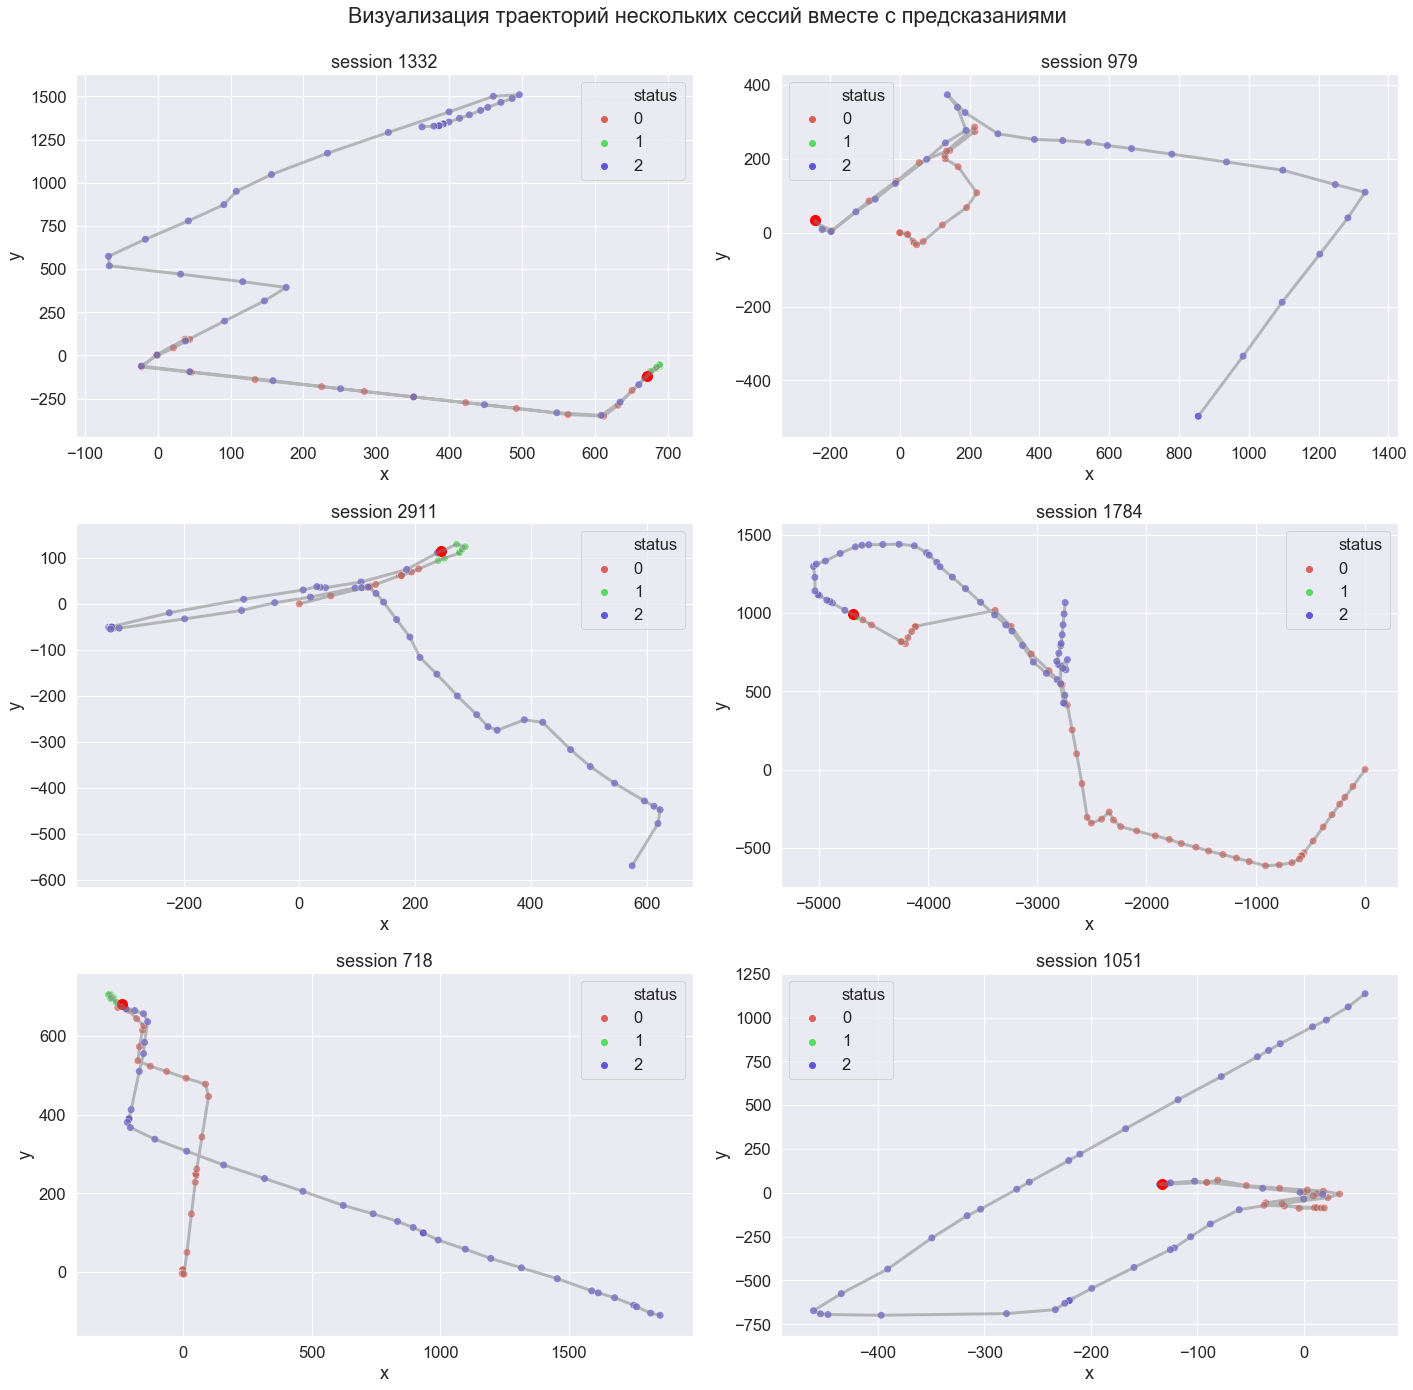

In [46]:
plt.figure(figsize=(20, 19))
plt.suptitle('Визуализация траекторий нескольких сессий \
вместе с предсказаниями', y=1.02, x=0.5)

for i, index in enumerate(alg_1_sample.index):
    plt.subplot(3, 2, i+1)
    
    session = data[data.session == index]
    
    plt.plot(session.x, session.y, alpha=0.5, color='grey', lw=3)
    
    sns.scatterplot(x='x', y='y', data=session, hue='status',
                    palette=sns.color_palette('hls', 3), alpha=0.7, s=60)
    plt.scatter(alg_1_sample.iloc[i, 0], alg_1_sample.iloc[i, 1],
                color='red', s=100, alpha=1)
    
    plt.title(f'session {index}')
    plt.xlabel('x')
    plt.ylabel('y')
    
plt.tight_layout()

***Вывод:***

На графиках можно заметить, что методы кластеризации, несмотря на усреднение их результатов, в основном находили точки, близкие к смене статуса. Это может говорить о том, что если водитель и забывает вовремя включить нужный статус, то вспоминает он об этом довольно быстро. 

Также некоторые результаты объяснимы и логически: например, на сессии 979 очевидно, что водитель поехал в окрестность точки (-200, 0) чтобы забрать там пассажира, развернуться и поехать в другую сторону, а предложенный метод в качестве точки посадки выбрал как раз крайнюю точку этого пути до пассажира. Похожую ситуацию можно заметить и в сессиях с номерами 718 и 1051.

В конечном итоге можно сказать, что предложенное решение может хорошо справляться с выявлением действительного места, где водитель ожидал пассажира, а в случае ошибки, если водитель дейтвительно поставил статус 2 вовремя, а мы решили иначе, наше предсказание все равно будет достаточно близко к истинной точке посадки.